In [1]:
import os
import tensorflow as tf
import cv2
import keras
import matplotlib.image as mpimg
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomFlip
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
!pip install split-folders

In [218]:
import splitfolders

input_dir = "./input/the-simpsons-characters-dataset/"
output_dir = "./data"

splitfolders.ratio(input_dir, output=output_dir, seed=66, ratio=(0.8, 0.1, 0.1))

Copying files: 20933 files [00:26, 788.95 files/s]


In [155]:

train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

image_size = (180, 180, 3)
# number of epochs to train top model 
epochs = 50 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 100

labels = os.listdir(train_dir)

In [156]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [185]:
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)

val_set = test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False
)

Found 24395 images belonging to 42 classes.
Found 2073 images belonging to 42 classes.
Found 2133 images belonging to 42 classes.


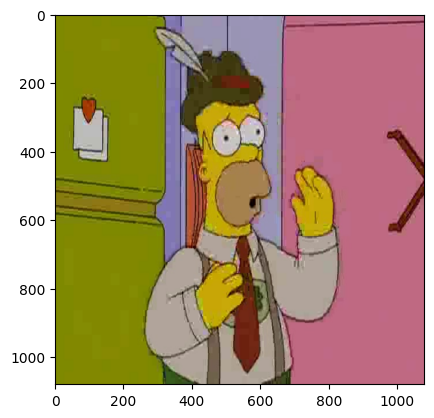

In [158]:
img_path = "./data/train/homer_simpson/pic_0028.jpg"
img = image.load_img(img_path, target_size=(1080, 1080, 3))
plt.imshow(img)
plt.show()

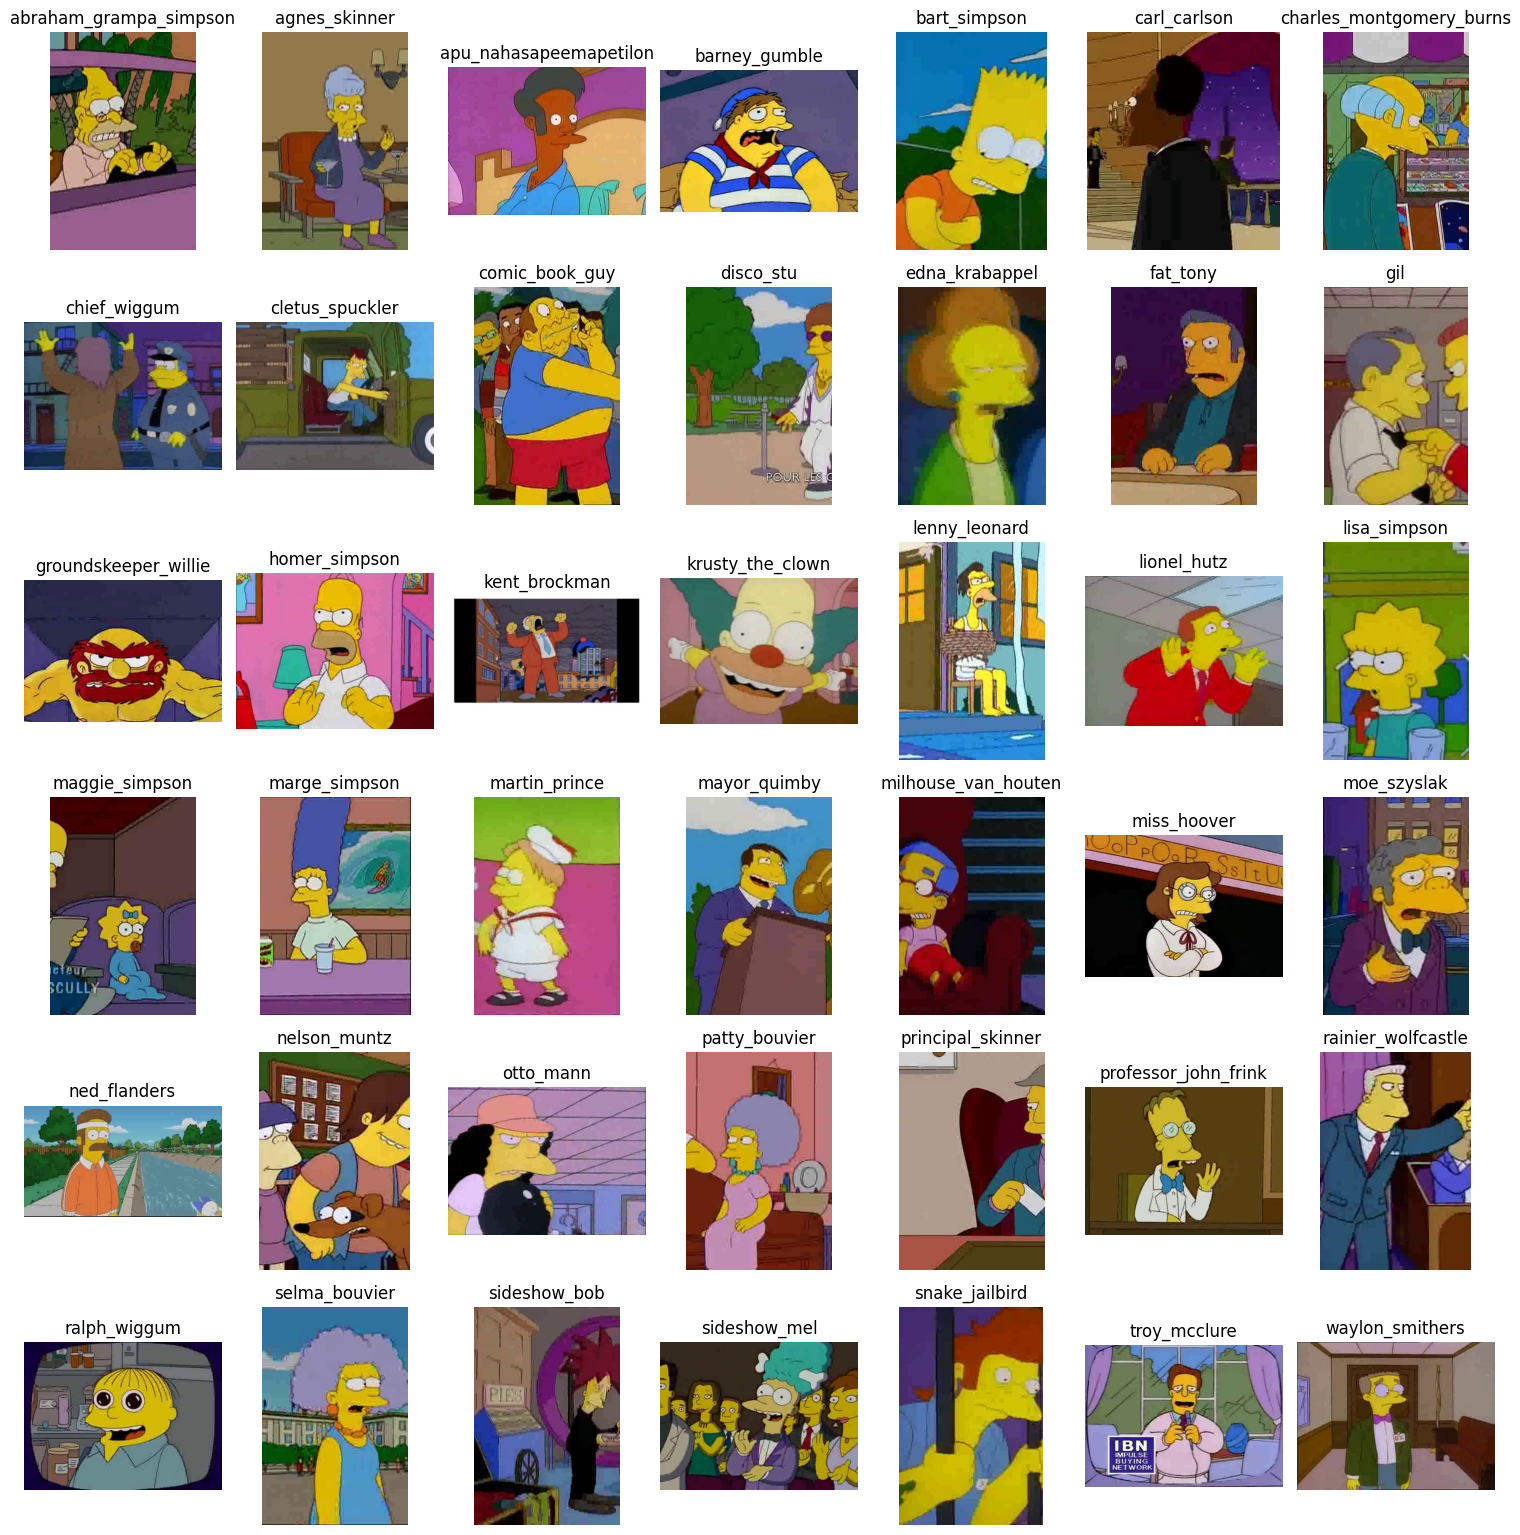

In [159]:
classes = list(training_set.class_indices.keys())
train_dir = './data/train'

def plot_image(size):
    plt.figure(figsize=(15, 18))
    for i, class_1 in enumerate(classes):

        folder_path = f"{train_dir}/{class_1}"
        files = os.listdir(folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
        random_file = random.choice(files)

        plt.subplot(size, size, i + 1)
        img = mpimg.imread(f"{folder_path}/{random_file}")
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_1)
    plt.tight_layout()
    plt.show()


plot_image(7)

In [160]:
def plot_size(len_l):
    plt.figure(figsize=(15, 15))
    ax = sns.barplot(x=len_l, y=classes, orient="h", color="navy")
    ax.set_xticks(np.arange(0, 2000, 2000))
    ax.set_xlabel("Number of Images")
    ax.set_ylabel("Classes")
    ax.set_title("Number of samples for each class", fontsize=20)
    for i, p in enumerate(ax.patches):
        ax.text(
            p.get_width(),
            p.get_y() + p.get_height() / 2.0,
            "{}".format(len_l[i]),
            va="center",
            fontsize=15,
        )

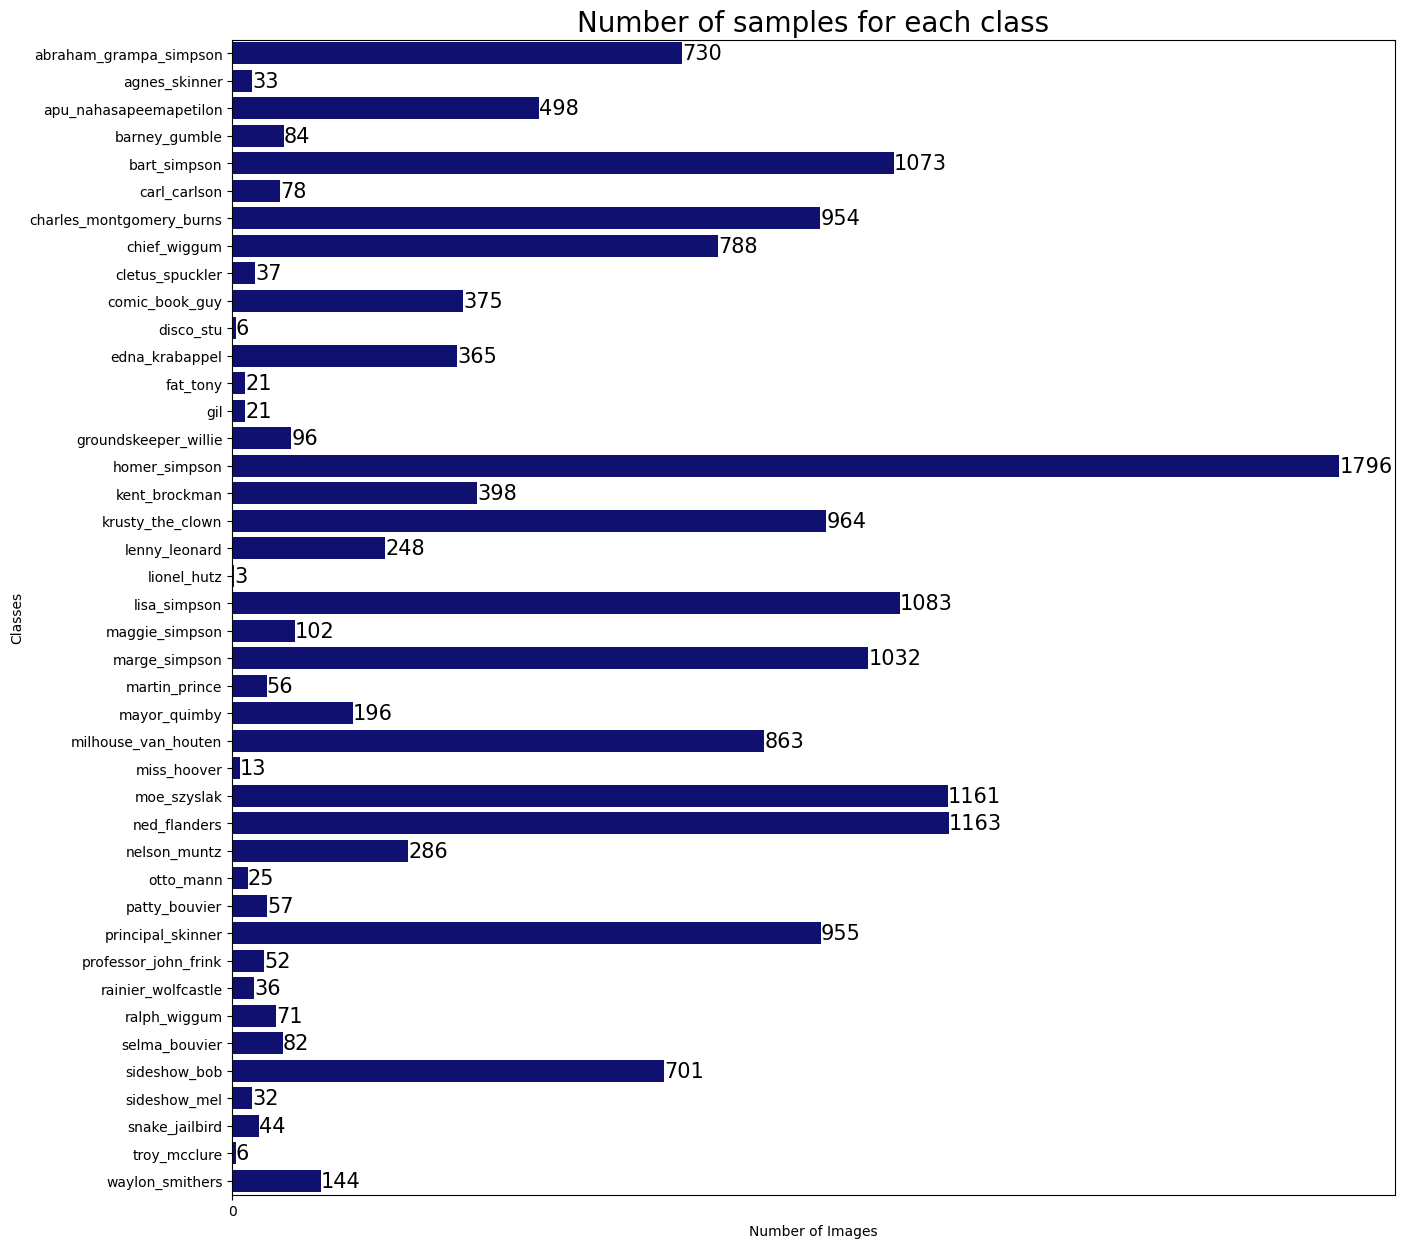

In [306]:
len_list = []

for i, class_ in enumerate(classes):
    len_list.append(len(os.listdir(f"{train_dir}/{class_}")))
        
plot_size(len_list)

In [307]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image

for i, class_ in enumerate(classes):
    if len_list[i] < 100:
        folder_path = f"{train_dir}/{class_}"
        files = os.listdir(folder_path)
        seq = len_list[i]
        for file_ in files:
            for i in range(9):
                img = mpimg.imread(f"{folder_path}/{file_}")
                
                image = tf.io.read_file(f"{folder_path}/{file_}")
                image = tf.image.decode_jpeg(image, channels=3)
                augmented_image = augment_image(image)
                img = Image.fromarray(augmented_image.numpy())
                padded_number = str(seq).zfill(4)
                img.save(os.path.join(folder_path, f"pic_{padded_number}.png"))
                
                
                seq += 1

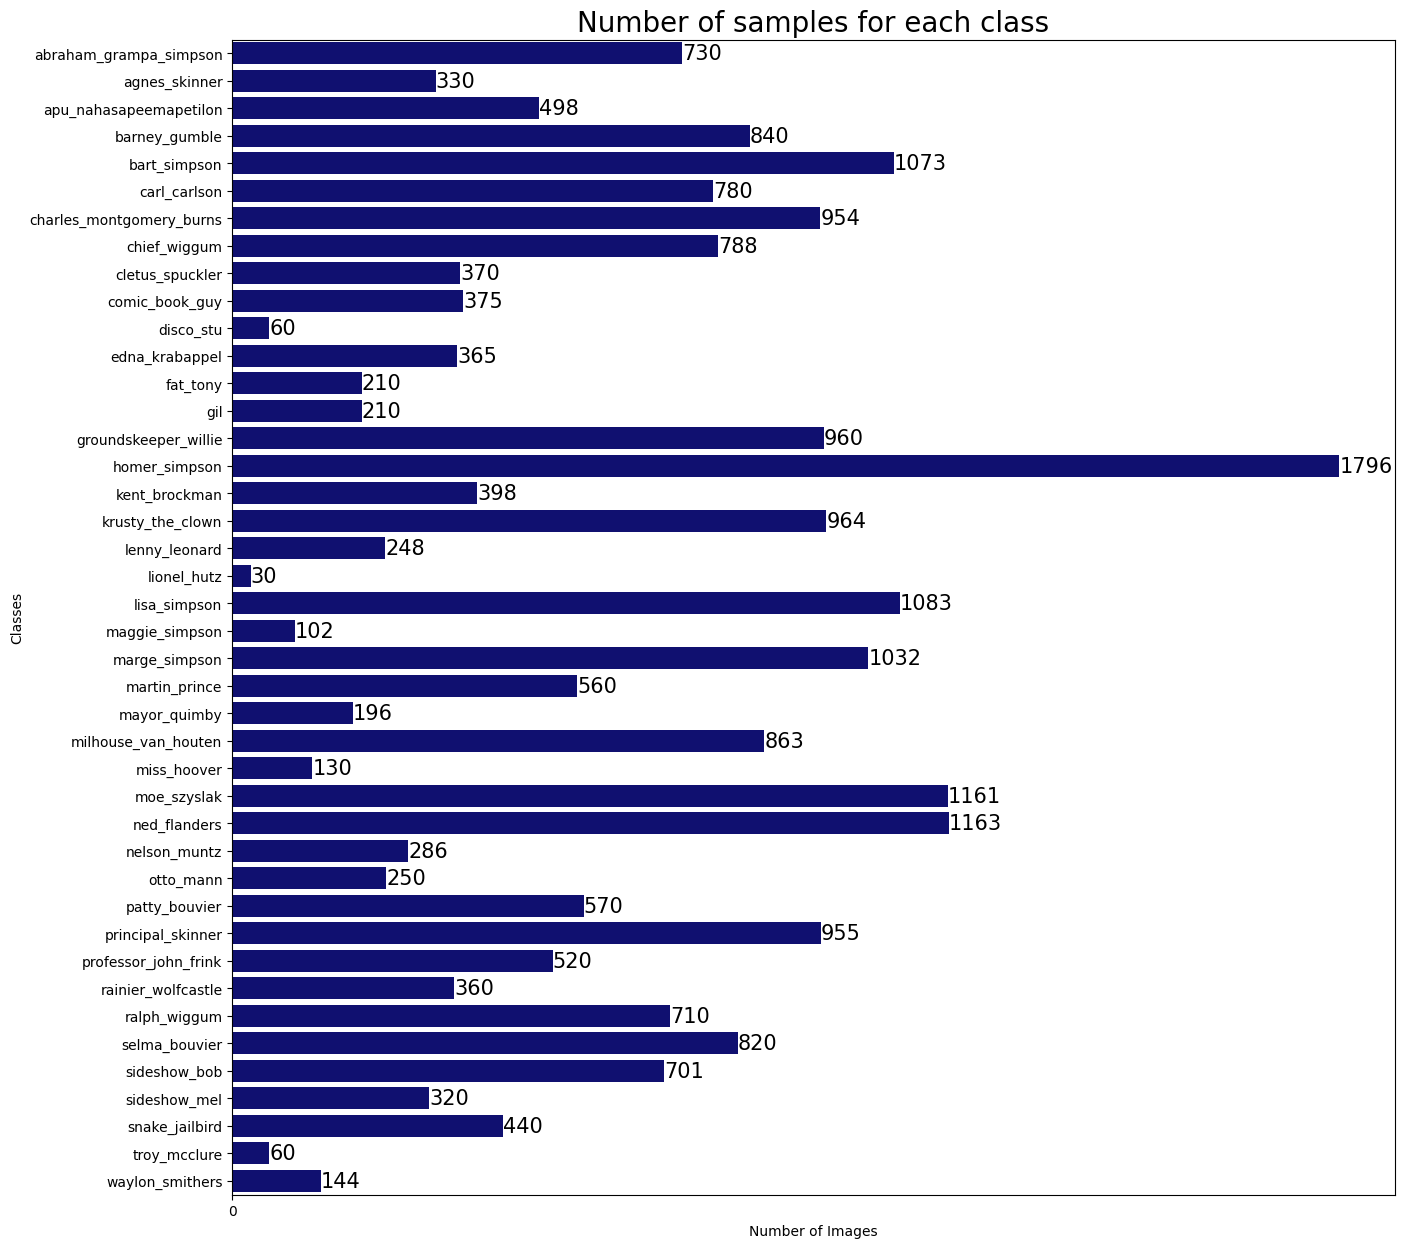

In [308]:
len_list_ = []

for i, class_ in enumerate(classes):
    len_list_.append(len(os.listdir(f"{train_dir}/{class_}")))
        
plot_size(len_list_)

In [164]:
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)

Found 24395 images belonging to 42 classes.
Found 2073 images belonging to 42 classes.
Found 2133 images belonging to 42 classes.


### Customeized CNN model



The following is referenced from [Simpsons Image Classification -CNN | Val_acc=93%](https://www.kaggle.com/code/everydaycodings/simpsons-image-classification-cnn-val-acc-93)

In [15]:
# model_cus = Sequential()
# model_cus.add(Conv2D(32, (3, 3), padding="same", input_shape=image_size, activation="relu"))
# model_cus.add(Conv2D(32, (3, 3), activation="relu"))
# model_cus.add(MaxPooling2D(pool_size=(2, 2)))
# model_cus.add(Dropout(0.2))

# model_cus.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
# model_cus.add(Conv2D(64, (3, 3), activation="relu"))
# model_cus.add(MaxPooling2D(pool_size=(2, 2)))
# model_cus.add(Dropout(0.2))

# model_cus.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
# model_cus.add(Conv2D(256, (3, 3), activation="relu"))
# model_cus.add(MaxPooling2D(pool_size=(2, 2)))
# model_cus.add(Dropout(0.2))

# model_cus.add(Flatten())
# model_cus.add(Dense(1024, activation="relu"))
# model_cus.add(Dropout(0.5))
# model_cus.add(Dense(len(labels), activation="softmax"))

In [16]:
# model_cus.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
# model_cus.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 64)        36928     
                                                      

In [37]:
checkpoint_filepath_cus = "./models/cus.h5"

# model_cus_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath_cus,
#     save_weights_only=False,
#     monitor="val_accuracy",
#     mode="max",
#     save_best_only=True,
# )

# callbacks = [
#     EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
#     model_cus_checkpoint_callback,
# ]

In [19]:
# history = model_cus.fit(
#     training_set, epochs=epochs, validation_data=val_set, callbacks=callbacks
# )

Epoch 1/50
280/280 [==============================] - 306s 1s/step - loss: 2.9442 - accuracy: 0.1712 - val_loss: 2.3632 - val_accuracy: 0.3545
Epoch 2/50
280/280 [==============================] - 104s 370ms/step - loss: 2.2720 - accuracy: 0.3321 - val_loss: 1.8108 - val_accuracy: 0.5177
Epoch 3/50
280/280 [==============================] - 105s 374ms/step - loss: 1.8682 - accuracy: 0.4502 - val_loss: 1.3935 - val_accuracy: 0.6346
Epoch 4/50
280/280 [==============================] - 111s 397ms/step - loss: 1.4653 - accuracy: 0.5621 - val_loss: 1.1640 - val_accuracy: 0.6891
Epoch 5/50
280/280 [==============================] - 106s 378ms/step - loss: 1.1349 - accuracy: 0.6576 - val_loss: 0.9927 - val_accuracy: 0.7373
Epoch 6/50
280/280 [==============================] - 211s 753ms/step - loss: 0.9029 - accuracy: 0.7266 - val_loss: 0.8827 - val_accuracy: 0.7686
Epoch 7/50
280/280 [==============================] - 160s 568ms/step - loss: 0.7177 - accuracy: 0.7781 - val_loss: 0.8115 - va

**Trends for accuracy and loss: training dataset versus validation set**

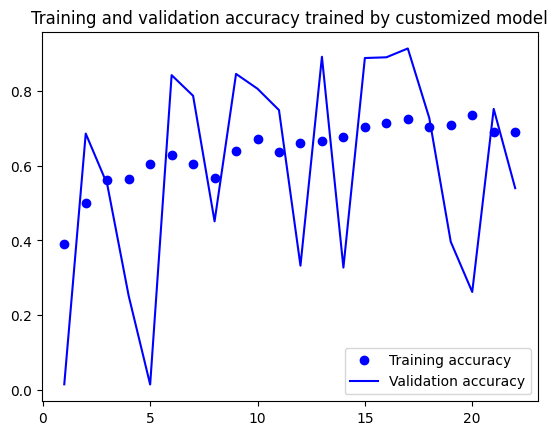

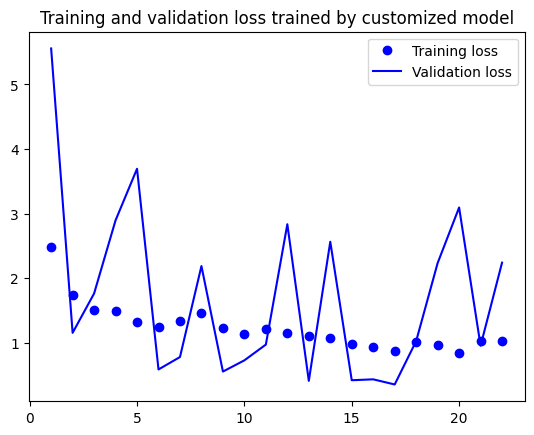

In [195]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy trained by customized model")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss trained by customized model")
plt.legend()
plt.show()

**Load highest val-accuracy model**

In [42]:
best_from_custome_defined_model = keras.models.load_model(checkpoint_filepath_cus)

Table below is referenced from Keras (https://keras.io/api/applications/)

| **Model** | **Size (MB)** | **Top-1 Accuracy** | **Top-5 Accuracy** | **Parameters** | **Depth** | **Time (ms) per inference step (CPU)** | **Time (ms) per inference step (GPU)** |
| --- | --- | --- | --- | --- | --- | --- | --- |
| [Xception](https://keras.io/api/applications/xception) | 88  | 79.0% | 94.5% | 22.9M | 81  | 109.4 | 8.1 |
| [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) | 528 | 71.3% | 90.1% | 138.4M | 16  | 69.5 | 4.2 |
| [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) | 549 | 71.3% | 90.0% | 143.7M | 19  | 84.8 | 4.4 |
| [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function) | 98  | 74.9% | 92.1% | 25.6M | 107 | 58.2 | 4.6 |
| [ResNet50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) | 98  | 76.0% | 93.0% | 25.6M | 103 | 45.6 | 4.4 |
| [ResNet101](https://keras.io/api/applications/resnet/#resnet101-function) | 171 | 76.4% | 92.8% | 44.7M | 209 | 89.6 | 5.2 |
| [ResNet101V2](https://keras.io/api/applications/resnet/#resnet101v2-function) | 171 | 77.2% | 93.8% | 44.7M | 205 | 72.7 | 5.4 |
| [ResNet152](https://keras.io/api/applications/resnet/#resnet152-function) | 232 | 76.6% | 93.1% | 60.4M | 311 | 127.4 | 6.5 |
| [ResNet152V2](https://keras.io/api/applications/resnet/#resnet152v2-function) | 232 | 78.0% | 94.2% | 60.4M | 307 | 107.5 | 6.6 |
| [InceptionV3](https://keras.io/api/applications/inceptionv3) | 92  | 77.9% | 93.7% | 23.9M | 189 | 42.2 | 6.9 |
| [InceptionResNetV2](https://keras.io/api/applications/inceptionresnetv2) | 215 | 80.3% | 95.3% | 55.9M | 449 | 130.2 | 10.0 |
| [MobileNet](https://keras.io/api/applications/mobilenet) | 16  | 70.4% | 89.5% | 4.3M | 55  | 22.6 | 3.4 |
| [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) | 14  | 71.3% | 90.1% | 3.5M | 105 | 25.9 | 3.8 |
| [DenseNet121](https://keras.io/api/applications/densenet/#densenet121-function) | 33  | 75.0% | 92.3% | 8.1M | 242 | 77.1 | 5.4 |
| [DenseNet169](https://keras.io/api/applications/densenet/#densenet169-function) | 57  | 76.2% | 93.2% | 14.3M | 338 | 96.4 | 6.3 |
| [DenseNet201](https://keras.io/api/applications/densenet/#densenet201-function) | 80  | 77.3% | 93.6% | 20.2M | 402 | 127.2 | 6.7 |
| [NASNetMobile](https://keras.io/api/applications/nasnet/#nasnetmobile-function) | 23  | 74.4% | 91.9% | 5.3M | 389 | 27.0 | 6.7 |
| [NASNetLarge](https://keras.io/api/applications/nasnet/#nasnetlarge-function) | 343 | 82.5% | 96.0% | 88.9M | 533 | 344.5 | 20.0 |
| [EfficientNetB0](https://keras.io/api/applications/efficientnet/#efficientnetb0-function) | 29  | 77.1% | 93.3% | 5.3M | 132 | 46.0 | 4.9 |
| [EfficientNetB1](https://keras.io/api/applications/efficientnet/#efficientnetb1-function) | 31  | 79.1% | 94.4% | 7.9M | 186 | 60.2 | 5.6 |
| [EfficientNetB2](https://keras.io/api/applications/efficientnet/#efficientnetb2-function) | 36  | 80.1% | 94.9% | 9.2M | 186 | 80.8 | 6.5 |
| [EfficientNetB3](https://keras.io/api/applications/efficientnet/#efficientnetb3-function) | 48  | 81.6% | 95.7% | 12.3M | 210 | 140.0 | 8.8 |
| [EfficientNetB4](https://keras.io/api/applications/efficientnet/#efficientnetb4-function) | 75  | 82.9% | 96.4% | 19.5M | 258 | 308.3 | 15.1 |
| [EfficientNetB5](https://keras.io/api/applications/efficientnet/#efficientnetb5-function) | 118 | 83.6% | 96.7% | 30.6M | 312 | 579.2 | 25.3 |
| [EfficientNetB6](https://keras.io/api/applications/efficientnet/#efficientnetb6-function) | 166 | 84.0% | 96.8% | 43.3M | 360 | 958.1 | 40.4 |
| [EfficientNetB7](https://keras.io/api/applications/efficientnet/#efficientnetb7-function) | 256 | 84.3% | 97.0% | 66.7M | 438 | 1578.9 | 61.6 |
| [EfficientNetV2B0](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b0-function) | 29  | 78.7% | 94.3% | 7.2M | \-  | \-  | \-  |
| [EfficientNetV2B1](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b1-function) | 34  | 79.8% | 95.0% | 8.2M | \-  | \-  | \-  |
| [EfficientNetV2B2](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b2-function) | 42  | 80.5% | 95.1% | 10.2M | \-  | \-  | \-  |
| [EfficientNetV2B3](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b3-function) | 59  | 82.0% | 95.8% | 14.5M | \-  | \-  | \-  |
| [EfficientNetV2S](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2s-function) | 88  | 83.9% | 96.7% | 21.6M | \-  | \-  | \-  |
| [EfficientNetV2M](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2m-function) | 220 | 85.3% | 97.4% | 54.4M | \-  | \-  | \-  |
| [EfficientNetV2L](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2l-function) | 479 | 85.7% | 97.5% | 119.0M | \-  | \-  | \-  |
| [ConvNeXtTiny](https://keras.io/api/applications/convnext/#convnexttiny-function) | 109.42 | 81.3% | \-  | 28.6M | \-  | \-  | \-  |
| [ConvNeXtSmall](https://keras.io/api/applications/convnext/#convnextsmall-function) | 192.29 | 82.3% | \-  | 50.2M | \-  | \-  | \-  |
| [ConvNeXtBase](https://keras.io/api/applications/convnext/#convnextbase-function) | 338.58 | 85.3% | \-  | 88.5M | \-  | \-  | \-  |
| [ConvNeXtLarge](https://keras.io/api/applications/convnext/#convnextlarge-function) | 755.07 | 86.3% | \-  | 197.7M | \-  | \-  | \-  |
| [ConvNeXtXLarge](https://keras.io/api/applications/convnext/#convnextxlarge-function) | 1310 | 86.7% | \-  | 350.1M | \-  | \-  | \-  |

### MobileNetV2 model

The following is referenced from [Recognize the Simpsons TensorFlow (88% acc.)](https://www.kaggle.com/code/databeru/recognize-the-simpsons-tensorflow-88-acc)

In [15]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [16]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation="relu")(pretrained_model.output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)

outputs = tf.keras.layers.Dense(42, activation="softmax")(x)
model_MNV2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_MNV2.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [17]:
model_MNV2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [18]:
model_MNV2.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

checkpoint_filepath_MNV2 = "./models/MNV2.h5"

model_MNV2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_MNV2,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

callbacks_MNV2 = [
    model_MNV2_checkpoint_callback,
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
]

history_MNV2 = model_MNV2.fit(
    training_set, validation_data=val_set, epochs=50, callbacks=callbacks_MNV2
)

Epoch 1/50
280/280 [==============================] - 156s 551ms/step - loss: 2.2835 - accuracy: 0.3367 - val_loss: 1.7115 - val_accuracy: 0.5357
Epoch 2/50
280/280 [==============================] - 119s 424ms/step - loss: 1.8543 - accuracy: 0.4590 - val_loss: 1.6226 - val_accuracy: 0.5599
Epoch 3/50
280/280 [==============================] - 116s 414ms/step - loss: 1.6873 - accuracy: 0.4985 - val_loss: 1.4653 - val_accuracy: 0.5982
Epoch 4/50
280/280 [==============================] - 105s 374ms/step - loss: 1.5669 - accuracy: 0.5324 - val_loss: 1.4401 - val_accuracy: 0.5968
Epoch 5/50
280/280 [==============================] - 118s 423ms/step - loss: 1.4772 - accuracy: 0.5542 - val_loss: 1.4499 - val_accuracy: 0.5925
Epoch 6/50
280/280 [==============================] - 113s 404ms/step - loss: 1.4065 - accuracy: 0.5758 - val_loss: 1.3700 - val_accuracy: 0.6143
Epoch 7/50
280/280 [==============================] - 110s 393ms/step - loss: 1.3442 - accuracy: 0.5939 - val_loss: 1.3111 -

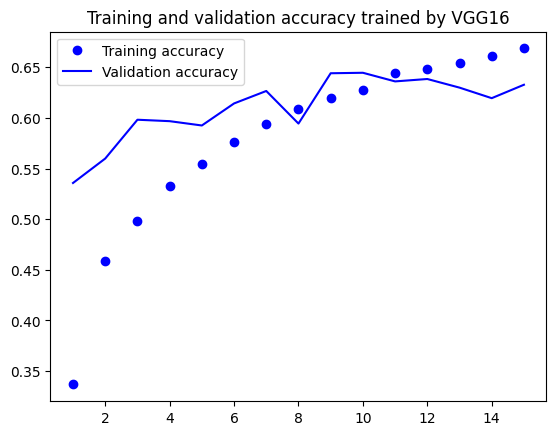

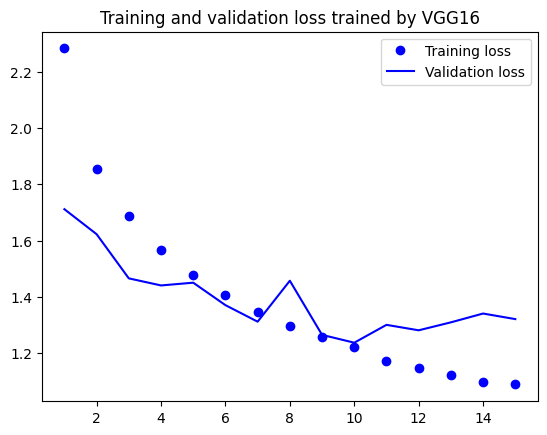

In [19]:
acc = history_MNV2.history["accuracy"]
val_acc = history_MNV2.history["val_accuracy"]
loss = history_MNV2.history["loss"]
val_loss = history_MNV2.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy trained by VGG16")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss trained by VGG16")
plt.legend()
plt.show()

**Load highest val-accuracy model - Mobile Net V2**

In [41]:
best_from_custome_MNV2_model = keras.models.load_model(checkpoint_filepath_MNV2)

### ResNet50

The following is referenced from [CNN + ResNet](https://www.kaggle.com/code/vellyy/cnn-resnet)

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow.keras.optimizers.legacy

In [22]:
model_RN50=Sequential()
model_RN50.add(ResNet50(include_top=False,
               pooling='max'))
model_RN50.add(Flatten())
model_RN50.add(Dense(1024, activation="relu"))
model_RN50.add(Dropout(0.5))
model_RN50.add(Dense(len(labels), activation='softmax'))

In [23]:
model_RN50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 42)                43050     
                                                                 
Total params: 25,728,938
Trainable params: 25,675,818
Non-trainable params: 53,120
_________________________________________________________________


In [32]:
model_RN50.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
checkpoint_filepath_RN50 = "./models/RN50.h5"

model_RN50_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_RN50,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

callbacks_MNV2 = [
    model_RN50_checkpoint_callback,
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
]

In [30]:
training_set_RN50 = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size[:2],
    batch_size=50,
    class_mode="categorical",
    color_mode="rgb",
)

val_set_RN50 = test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size[:2],
    batch_size=50,
    class_mode="categorical",
    color_mode="rgb",
)

Found 27919 images belonging to 42 classes.
Found 2113 images belonging to 42 classes.


In [34]:
history_RN50 = model_RN50.fit(
    training_set_RN50, epochs=50, validation_data=val_set_RN50, callbacks=callbacks_MNV2
)

Epoch 1/50
559/559 [==============================] - 147s 256ms/step - loss: 2.4785 - accuracy: 0.3897 - val_loss: 5.5559 - val_accuracy: 0.0142
Epoch 2/50
559/559 [==============================] - 142s 254ms/step - loss: 1.7416 - accuracy: 0.5006 - val_loss: 1.1553 - val_accuracy: 0.6862
Epoch 3/50
559/559 [==============================] - 141s 252ms/step - loss: 1.5094 - accuracy: 0.5624 - val_loss: 1.7636 - val_accuracy: 0.5504
Epoch 4/50
559/559 [==============================] - 141s 252ms/step - loss: 1.4910 - accuracy: 0.5635 - val_loss: 2.8962 - val_accuracy: 0.2513
Epoch 5/50
559/559 [==============================] - 141s 252ms/step - loss: 1.3205 - accuracy: 0.6036 - val_loss: 3.6942 - val_accuracy: 0.0137
Epoch 6/50
559/559 [==============================] - 142s 254ms/step - loss: 1.2385 - accuracy: 0.6298 - val_loss: 0.5885 - val_accuracy: 0.8429
Epoch 7/50
559/559 [==============================] - 141s 252ms/step - loss: 1.3382 - accuracy: 0.6036 - val_loss: 0.7806 -

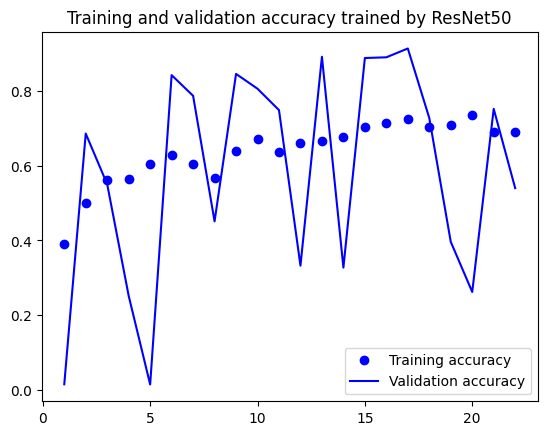

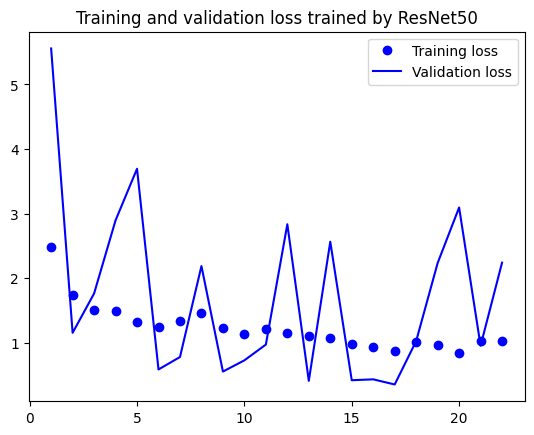

In [196]:
acc = history_RN50.history["accuracy"]
val_acc = history_RN50.history["val_accuracy"]
loss = history_RN50.history["loss"]
val_loss = history_RN50.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy trained by ResNet50")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss trained by ResNet50")
plt.legend()
plt.show()

**Load highest val-accuracy model - Res Net 50**

In [43]:
best_from_custome_RN50_model = keras.models.load_model(checkpoint_filepath_RN50)

### Predictions

In [90]:
best_from_custome_defined_model
best_from_custome_MNV2_model
best_from_custome_RN50_model

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [179]:
y_true = test_set.classes
y_test_true = keras.utils.to_categorical(y_true, num_classes=len(labels))
y_test_true = np.argmax(y_test_true, axis=1)

### Evaluation of **customized model** on test set

In [186]:
y_pred_defined = best_from_custome_defined_model.predict(test_set)

22/22 [==============================] - 2s 104ms/step


In [187]:
y_pred_defined = np.argmax(y_pred_defined, axis=1)
cm_defined = confusion_matrix(y_test_true, y_pred_defined)

In [192]:
class_report = classification_report(
    y_test_true, y_pred_defined, zero_division=1, target_names=labels
)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.92      0.98      0.95        92
           agnes_skinner       1.00      0.80      0.89         5
  apu_nahasapeemapetilon       0.98      1.00      0.99        63
           barney_gumble       1.00      1.00      1.00        12
            bart_simpson       0.99      0.97      0.98       135
            carl_carlson       1.00      1.00      1.00        11
charles_montgomery_burns       1.00      0.97      0.99       120
            chief_wiggum       0.99      0.99      0.99       100
         cletus_spuckler       1.00      1.00      1.00         6
          comic_book_guy       0.98      0.98      0.98        48
               disco_stu       1.00      1.00      1.00         2
          edna_krabappel       0.96      0.98      0.97        47
                fat_tony       1.00      1.00      1.00         4
                     gil       1.00      1.00      1.00         4
    groun

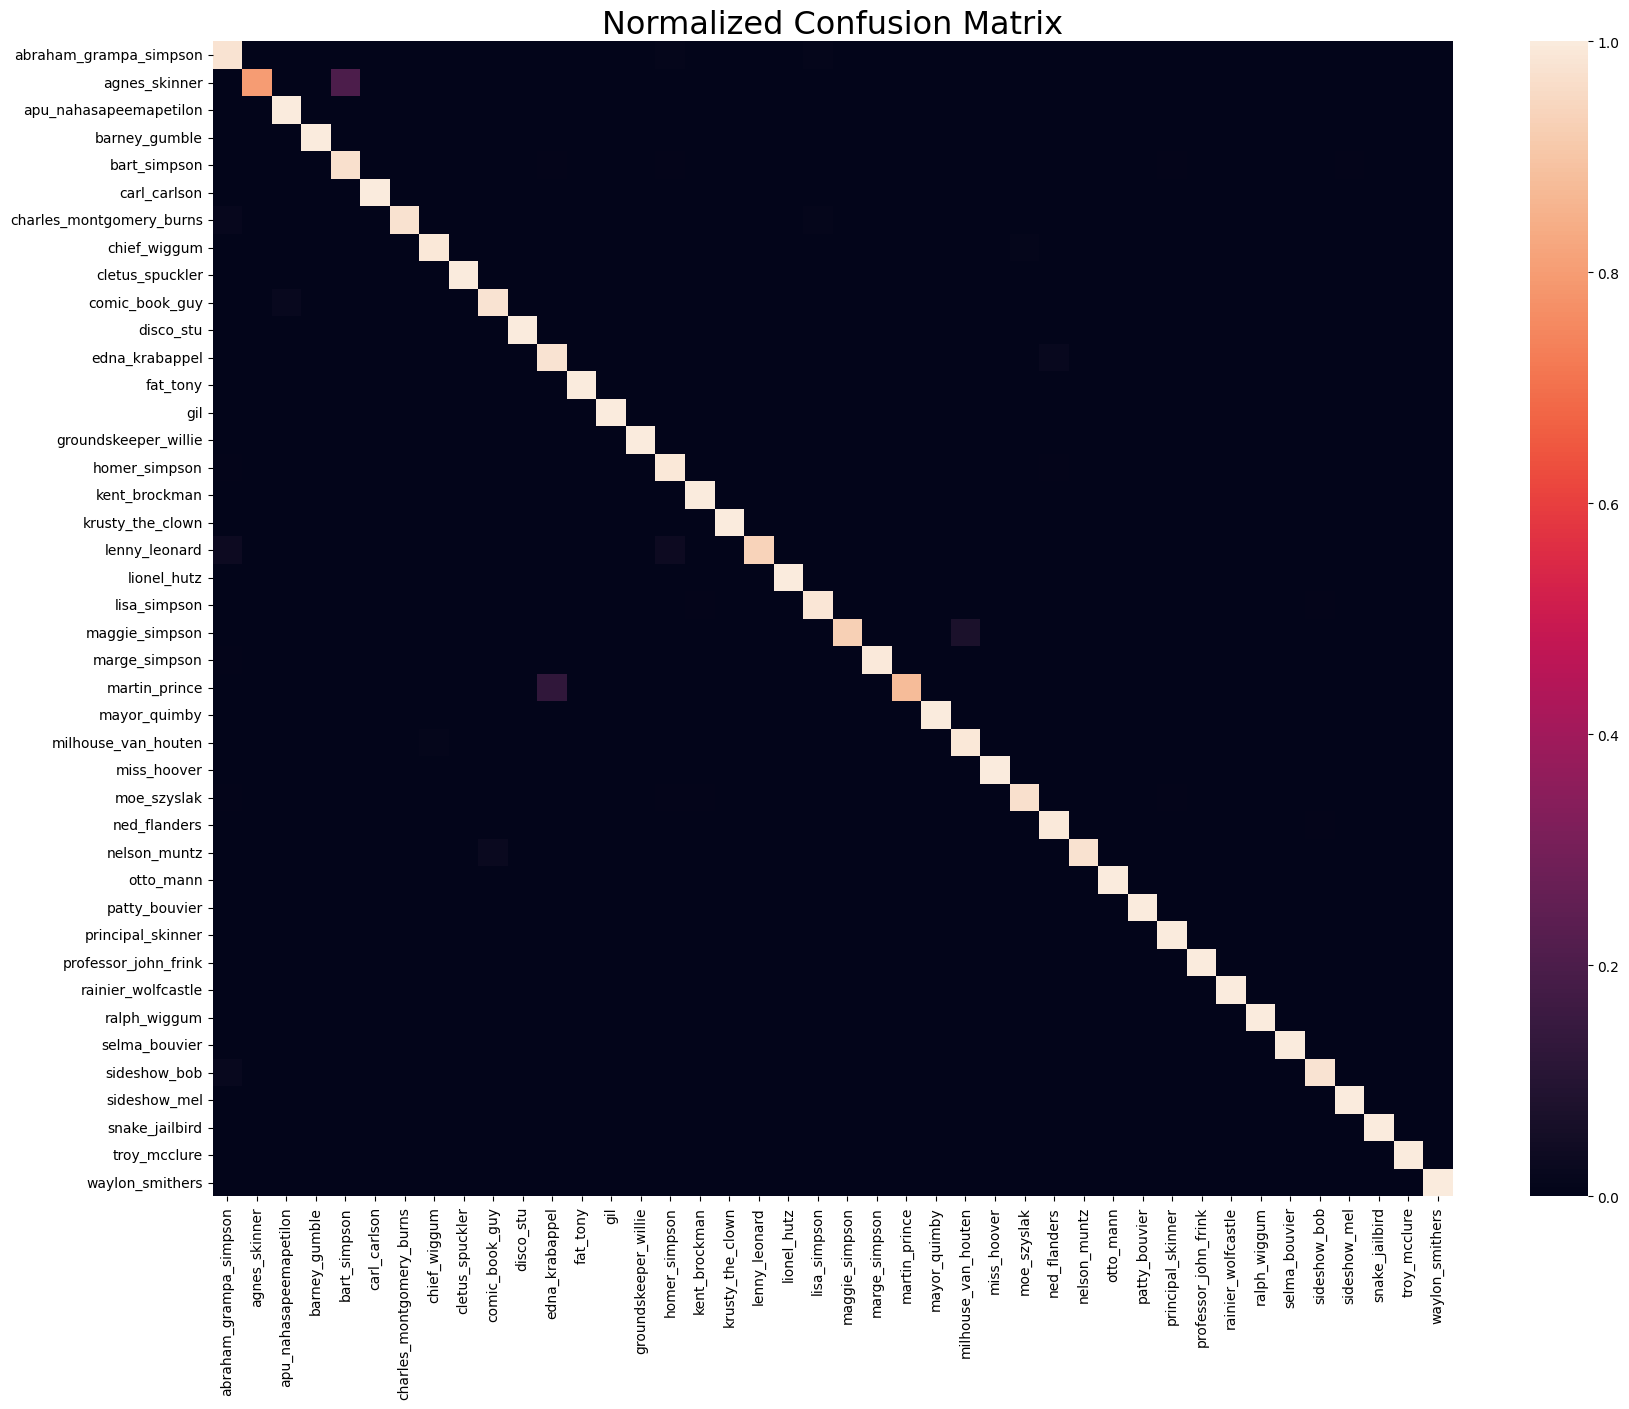

In [191]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test_true, y_pred_defined, normalize="true")
plt.figure(figsize=(20, 15))
sns.heatmap(
    cf_matrix,
    annot=False,
    xticklabels=labels,
    yticklabels=labels,
)
plt.title("Normalized Confusion Matrix", fontsize=23)
plt.show()

In [197]:
def plot_specific_images(a, b):
    plt.figure(figsize=(15, 18))
    for i, class_1 in enumerate([a, b]):

        folder_path = f"{train_dir}/{class_1}"
        files = os.listdir(folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
        random_file = random.choice(files)

        plt.subplot(2, 2, i + 1)
        img = mpimg.imread(f"{folder_path}/{random_file}")
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_1)
    plt.tight_layout()
    plt.show()

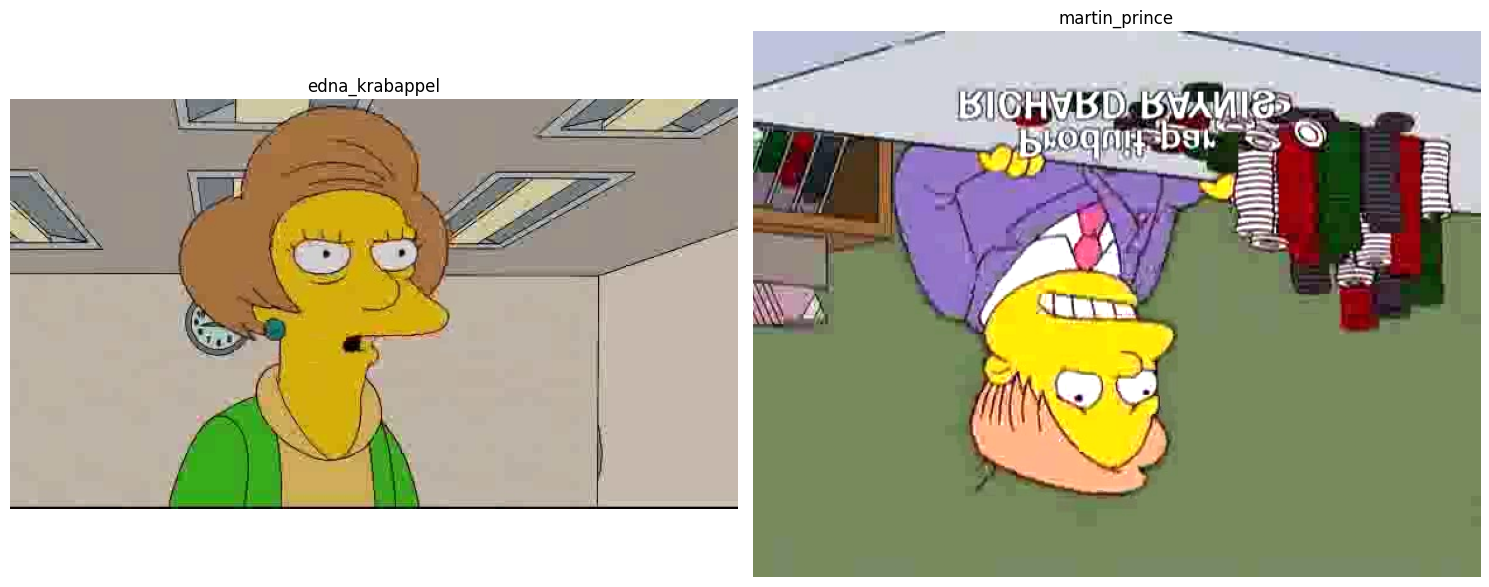

In [313]:
plot_specific_images('edna_krabappel', 'martin_prince')

echa_krabappel
martin_prince